In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene

In [2]:
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

print (df.head)
df.info()

<bound method NDFrame.head of                       EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  4599628364049201812      1565212345    247
244122         MainScreenAppear  5849806612437486590      1565212439    246
244123         MainScreenAppear  5746969938801999050      1565212483    246
244124         MainScreenAppear  5746969938801999050      1565212498    246
244125       OffersScreenAppear  5746969938801999050      1565212517    246

[244126 rows x 4 columns]>
<class 'pandas.core.frame.Data

In [3]:
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')
print(df['EventTimestamp'].head(10))

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
5   2019-07-25 11:48:43
6   2019-07-25 14:50:42
7   2019-07-25 20:14:37
8   2019-07-25 20:31:42
9   2019-07-26 03:35:12
Name: EventTimestamp, dtype: datetime64[ns]


In [4]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']

print (df.head(5))

                event_name              user_id     event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248


In [5]:
df['event_date'] = df['event_timestamp'].dt.date

print (df.head(5))

print('valores nulos:')
print(df.isnull().sum())

print ('tipos de datos:')
print(df.dtypes)

                event_name              user_id     event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

   event_date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25  
valores nulos:
event_name         0
user_id            0
event_timestamp    0
exp_id             0
event_date         0
dtype: int64
tipos de datos:
event_name                 object
user_id                     int64
event_timestamp    datetime64[ns]
exp_id                      int64
event_date                 object
dtype: object


#### Hasta aqui se completa el paso 1 y 2 del proyecto y se verifica que no se requiere mas limpiza de datos

In [6]:
total_eventos = len(df)
print("Total de eventos:", total_eventos)

Total de eventos: 244126


In [7]:
# Cantidad de usuarios únicos
usuarios_unicos = df['user_id'].nunique()
print("Usuarios únicos:", usuarios_unicos)

Usuarios únicos: 7551


In [8]:
promedio_eventos = total_eventos / usuarios_unicos
print("Promedio de eventos por usuario:", round(promedio_eventos, 2))


Promedio de eventos por usuario: 32.33


In [9]:
print("Fecha mínima:", df['event_timestamp'].min())
print("Fecha máxima:", df['event_timestamp'].max())

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


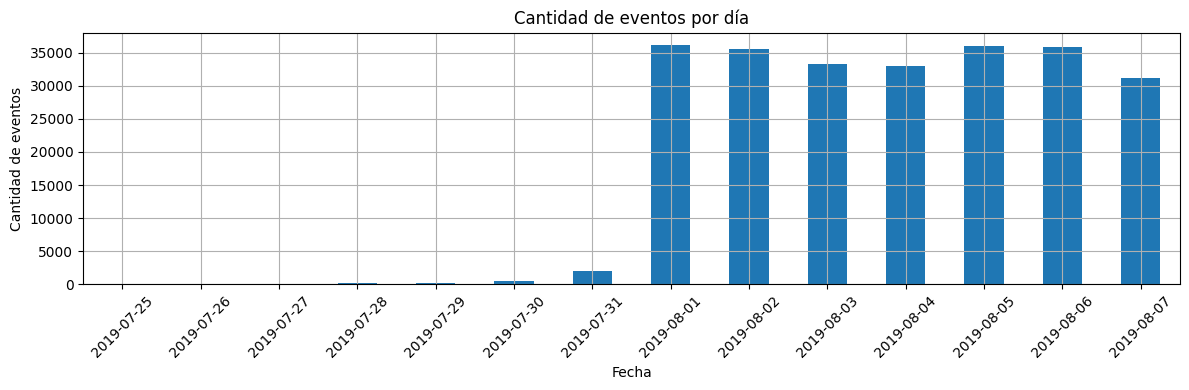

In [10]:
eventos_por_dia = df.groupby('event_date').size()

plt.figure(figsize=(12, 4))
eventos_por_dia.plot(kind='bar')
plt.title('Cantidad de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [11]:
# Filtramos a partir del 2019‑08‑01
fecha_inicio_completa = pd.to_datetime('2019-08-01').date()
df_filtrados = df[df['event_date'] >= fecha_inicio_completa]

print("Mínimo (filtrados):", df_filtrados['event_timestamp'].min())
print("Máximo (filtrados):", df_filtrados['event_timestamp'].max())


Mínimo (filtrados): 2019-08-01 00:07:28
Máximo (filtrados): 2019-08-07 21:15:17


In [12]:
# Calcular eventos por día en el dataset completo y en el filtrado
eventos_diarios_total    = df.groupby('event_date').size()
eventos_diarios_filtrados = df_filtrados.groupby('event_date').size()

# Ver cuántos días tienen al menos, digamos, 1.000 eventos
dias_estables = (eventos_diarios_filtrados >= 1000).sum()
total_dias   = eventos_diarios_filtrados.size


print(f"Porcentaje de días estables: {round(dias_estables/total_dias*100,2)}%")

Porcentaje de días estables: 100.0%


#### Se observa que entre el 25 y 31 de julio hay muy pocos eventos, por lo que se estima que a partir del primero de agosto es cuando los datos son consistentes por lo que se considera filtrar los datos a partir de esta fecha

In [13]:
eventos_perdidos = len(df) - len(df_filtrados)
usuarios_perdidos = df['user_id'].nunique() - df_filtrados['user_id'].nunique()

print(f"Eventos totales:        {len(df)}")
print(f"Eventos tras filtrado:  {len(df_filtrados)}")
print(f"Usuarios totales:       {df['user_id'].nunique()}")
print(f"Usuarios tras filtrado: {df_filtrados['user_id'].nunique()}")

Eventos totales:        244126
Eventos tras filtrado:  241298
Usuarios totales:       7551
Usuarios tras filtrado: 7534


Se pierden pocos usuarios comparado con el total, por lo que es razonable limpiar esa primera semana.

In [14]:
usuarios_por_grupo = (
    df_filtrados
    .groupby('exp_id')['user_id']
    .nunique()
    .rename('usuarios')
    .reset_index()
)
print(usuarios_por_grupo)

   exp_id  usuarios
0     246      2484
1     247      2513
2     248      2537


In [15]:
funnel = [
    'Tutorial',
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# Diccionarios para guardar resultados
usuarios_por_etapa = {}
total_usuarios = df_filtrados['user_id'].nunique()

for evento in funnel:
    usuarios = (
        df_filtrados[df_filtrados['event_name'] == evento]
        ['user_id']
        .nunique()
    )
    usuarios_por_etapa[evento] = usuarios

# Mostrar resultados
for etapa, usuarios in usuarios_por_etapa.items():
    pct = usuarios / total_usuarios * 100
    print(f"{etapa:25s}: {usuarios:5d} usuarios — {pct:.1f}% del total")

Tutorial                 :   840 usuarios — 11.1% del total
MainScreenAppear         :  7419 usuarios — 98.5% del total
OffersScreenAppear       :  4593 usuarios — 61.0% del total
CartScreenAppear         :  3734 usuarios — 49.6% del total
PaymentScreenSuccessful  :  3539 usuarios — 47.0% del total


In [16]:
# 1) Definir nuevo funnel
funnel2 = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

# 2) Contar usuarios por etapa en df_filtrados
usuarios_por_etapa2 = {
    evento: df_filtrados[df_filtrados['event_name'] == evento]['user_id'].nunique()
    for evento in funnel2
}
total_usuarios = df_filtrados['user_id'].nunique()

# 3) Mostrar totales y porcentajes
for etapa, usuarios in usuarios_por_etapa2.items():
    pct = usuarios / total_usuarios * 100
    print(f"{etapa:25s}: {usuarios:5d} usuarios — {pct:.1f}% del total")

# 4) Calcular conversiones entre cada paso
print("\nTasas de conversión entre etapas:")
for i in range(len(funnel2) - 1):
    ini, fin = funnel2[i], funnel2[i+1]
    ratio = usuarios_por_etapa2[fin] / usuarios_por_etapa2[ini] * 100
    print(f"{ini} → {fin:28s}: {ratio:.1f}%")

# 5) Funnel completo
funnel_completo2 = usuarios_por_etapa2[funnel2[-1]] / usuarios_por_etapa2[funnel2[0]] * 100
print(f"\n% que completa todo el funnel: {funnel_completo2:.1f}%")

MainScreenAppear         :  7419 usuarios — 98.5% del total
OffersScreenAppear       :  4593 usuarios — 61.0% del total
CartScreenAppear         :  3734 usuarios — 49.6% del total
PaymentScreenSuccessful  :  3539 usuarios — 47.0% del total

Tasas de conversión entre etapas:
MainScreenAppear → OffersScreenAppear          : 61.9%
OffersScreenAppear → CartScreenAppear            : 81.3%
CartScreenAppear → PaymentScreenSuccessful     : 94.8%

% que completa todo el funnel: 47.7%


Se recrea una el funnel (embudo) ya que solo el 11% de los usuario ven el tutorial pero practicamente todos (98.5%) vieron la pantalla principal, lo que hace que esto debemos descartarlo.

#### como se ve en los resultados un gran porcentaje de usuarios que vieron las ofertas pasan al carrito de compras, ademas de que un 94.8% de usuarios que agregaron algo en el carrito de compras hicieron la compra. 

#### por lo que se podria decir que el si mejoramos el sistema para que lleguen a las "ofertas" la tasa de conversion mejorara

In [17]:
top_event = df_filtrados['event_name'].value_counts().idxmax()
print("Evento más popular:", top_event)

Evento más popular: MainScreenAppear


#### logico ya que se podria decir que es el primer evento

In [18]:
def proporcion_evento(df, exp):
    usuarios = df[(df['exp_id'] == exp) & (df['event_name'] == top_event)]['user_id'].nunique()
    total = df[df['exp_id'] == exp]['user_id'].nunique()
    return usuarios / total

for exp in [246, 247, 248]:
    pct = proporcion_evento(df_filtrados, exp)
    print(f"Grupo {exp}: {pct:.3f}")


Grupo 246: 0.986
Grupo 247: 0.985
Grupo 248: 0.983


In [19]:
def series_binaria(df, exp):
    users = df[df['exp_id'] == exp]['user_id'].unique()
    happened = df[(df['exp_id'] == exp) & (df['event_name'] == top_event)]['user_id'].unique()
    return np.array([1 if u in happened else 0 for u in users])

s246 = series_binaria(df_filtrados, 246)
s247 = series_binaria(df_filtrados, 247)

In [20]:
stat, p_levene = levene(s246, s247)
print(f"\nLevene test p‑value (varianzas iguales?): {p_levene:.3f}")



Levene test p‑value (varianzas iguales?): 0.757


In [21]:
t_stat, p_t = ttest_ind(s246, s247, equal_var=(p_levene>0.05))
print(f"T‑test 246 vs 247 p‑value: {p_t:.3f}")

T‑test 246 vs 247 p‑value: 0.757


In [22]:
alpha = 0.10

# Función que devuelve la serie binaria para un evento y un experimento
def series_binaria(df, exp_id, evento):
    usuarios = df[df['exp_id'] == exp_id]['user_id'].unique()
    hicieron = df[(df['exp_id'] == exp_id) & (df['event_name'] == evento)]['user_id'].unique()
    return np.array([1 if u in hicieron else 0 for u in usuarios])

# Preparamos las tres series binarias para el top_event
s246 = series_binaria(df_filtrados, 246, top_event)
s247 = series_binaria(df_filtrados, 247, top_event)
s248 = series_binaria(df_filtrados, 248, top_event)

# Comparar 248 vs cada control
for control, serie_control in [(246, s246), (247, s247)]:
    stat_le, p_le = levene(serie_control, s248)
    t_stat, p_val = ttest_ind(serie_control, s248, equal_var=(p_le > alpha))
    print(f"\nComparación control {control} vs 248:")
    print(f"  Levene p‑value: {p_le:.4f}")
    print(f"  T‑test p‑value: {p_val:.4f}")
    if p_val > alpha:
        print("  → No hay diferencia significativa.")
    else:
        print("  → Sí hay diferencia significativa.")


Comparación control 246 vs 248:
  Levene p‑value: 0.2951
  T‑test p‑value: 0.2951
  → No hay diferencia significativa.

Comparación control 247 vs 248:
  Levene p‑value: 0.4588
  T‑test p‑value: 0.4588
  → No hay diferencia significativa.


In [23]:
# Unir los dos controles
users_246 = df_filtrados[df_filtrados['exp_id'] == 246]['user_id'].unique()
users_247 = df_filtrados[df_filtrados['exp_id'] == 247]['user_id'].unique()
users_A   = np.concatenate([users_246, users_247])

# Serie binaria para A combinado
serie_A = np.array([1 if u in df_filtrados[
    (df_filtrados['exp_id'].isin([246, 247])) & 
    (df_filtrados['event_name'] == top_event)
]['user_id'].unique() else 0 for u in users_A])

# Serie binaria para B
serie_B = s248

# Test Levene y t‑test
stat_le, p_le = levene(serie_A, serie_B)
t_stat, p_val = ttest_ind(serie_A, serie_B, equal_var=(p_le > alpha))
print("\nComparación controles combinados vs 248:")
print(f"  Levene p‑value: {p_le:.4f}")
print(f"  T‑test p‑value: {p_val:.4f}")
if p_val > alpha:
    print("  → No hay diferencia significativa.")
else:
    print("  → Sí hay diferencia significativa.")


Comparación controles combinados vs 248:
  Levene p‑value: 0.2943
  T‑test p‑value: 0.2943
  → No hay diferencia significativa.


#### No se encontraron diferencias significativas entre controles A/A ni entre los controles y el grupo de prueba para ninguno de los eventos analizados, incluso tras ajuste por Bonferroni. Las nuevas fuentes no impactan negativamente la interacción.

#### El cuello de botella esta en hacer que la gente vea mas ofertas. Tambien podria ser irrelevante el tutorial o dejarlo solo como un extra mas no para los pasos que se requieren para realizar un compra.


Tambien se concluye que la nueva tipografia no altera el comportamiento de los usuarios por lo tanto se podria cambiar sin esperar algo negativo.

####